In [ ]:
!pip install stable-baselines3[extra]
#!pip install stable-baselines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import numpy as np

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3 import DDPG
#from stable_baselines import TRPO

In [ ]:
#from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.ddpg.policies import MlpPolicy

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install odeintw
from odeintw import odeintw

class PassageEnv(Env):
    def __init__(self):
        # Limites y espacio de las acciones [omega1, omega2]
        self.action_space = Box(low=np.array([0,0,0]), high=np.array([1,1,1]))
        #  Limites y espacio de los estados: [\rho, sigma1, sigma2]

        """ rho = [ [0,0,0,0,0],       rho_max = [ [1,1,1,1,1],       omega_min = [0,0,0]
                    [0,0,0,0,0],                   [1,1,1,1,1],       omega_max = [1,1,1]
                    [0,0,0,0,0],                   [1,1,1,1,1],
                    [0,0,0,0,0],                   [1,1,1,1,1],
                    [0,0,0,0,0]]                   [1,1,1,1,1] ]                 """

        self.observation_space = Box(low=np.array([0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0]), 
                                high=np.array([1,1,1,1,1, 1,1,1,1,1, 1,1,1,1,1, 1,1,1,1,1, 1,1,1,1,1, 1,1,1]))
        # Set start state
        self.state = np.array([1,0,0,0,0,
                               0,0,0,0,0, 
                               0,0,0,0,0, 
                               0,0,0,0,0,
                               0,0,0,0,0, 0,0,0],dtype=np.complex128)

        self.length_trial = 0


    def refuerzo(self, p5, p2, p3, p4):
        return (-1 + 20*p5 - p2 - p3 - p4) #+ A(p2)

    def step(self, action):
        # Aplicar accion
        omega1 = action[0]
        omega2 = action[1]
        omega3 = action[2]

        # Cambiar el hamiltoniano
        def right_part(rho, t):
  
          hamiltonian = np.array([[    0    ,  -omega1 ,    0    ,    0    ,    0    ],
                                  [ -omega1 ,    0.1   , -omega3 ,    0    ,    0    ],
                                  [    0    ,  -omega3 ,   -0.1   , -omega3 ,    0    ],
                                  [    0    ,     0    , -omega3 ,   0.1   , -omega2 ],
                                  [    0    ,     0    ,     0   , -omega2 ,   0.2   ]],
                                  dtype=np.complex128)
          return (np.dot(hamiltonian, rho) - np.dot(rho, hamiltonian)) / (1j)

        # Evolucion temporal
        N = 100
        omegamax = 1
        dt = (10*np.pi/omegamax)/N
        #tmax = 10
        tpasos = np.linspace(0,dt,N)
        rho = np.array([[self.state[i] for i in range(0,5)],
                        [self.state[i] for i in range(5,10)],
                        [self.state[i] for i in range(10,15)],
                        [self.state[i] for i in range(15,20)],
                        [self.state[i] for i in range(20,25)]], dtype=np.complex128)

        result = odeintw(right_part, rho, tpasos)
        final_result = result[-1]
        final_result = np.reshape(final_result,(25,))

        # Nuevo estado a partir de la matriz densidad obtenida
        result = final_result
        self.state = np.array([result[0], result[1], result[2], result[3], result[4],
                               result[5], result[6], result[7], result[8], result[9],
                               result[10], result[11], result[12], result[13], result[14],
                               result[15], result[16], result[17], result[18], result[19],
                               result[20], result[21], result[22], result[23], result[24],
                               omega1, omega2,omega3])
        
        done =False

        # Calcular el refuerzo
        reward = self.refuerzo(self.state[24], self.state[6], self.state[12], self.state[18] )

      
        if self.state[6]>0.05 or self.state[12]>0.05  or self.state[18]>0.05 :
          reward -= 10

        self.length_trial += 1
      
        if self.state[24] >= 0.98 and self.length_trial ==100:
            reward += 10000
            done = True


        if self.length_trial >= 100:
            done = True


        info = {}

        return self.state, reward, done, info

    def render(self):
        pass

    def reset(self):
        self.state = np.array([1,0,0,0,0,
                               0,0,0,0,0, 
                               0,0,0,0,0, 
                               0,0,0,0,0,
                               0,0,0,0,0, 0,0,0],dtype=np.complex128)
        self.length_trial = 0
        return self.state

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#env = gym.make('CartPole-v1')
env = PassageEnv()

#model = PPO(MlpPolicy, env, verbose=0)
model = DDPG(MlpPolicy, env)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [ ]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Train the agent for 10000 steps
N_steps = 5000
model.learn(total_timesteps=N_steps)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  self.actions[env_idx]
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/off_policy_algorithm.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  next_obs[i] = infos[i]["terminal_observation"]


In [ ]:
# Evaluate the trained agent
#mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
#mean_reward_before_train = evaluate(model, num_episodes=100)

#print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
# Leyendo archivos desde Google drive
GOOGLE_DRIVE = '/content/google_drive'
import numpy as np
from google.colab import drive
drive.mount(GOOGLE_DRIVE)
path = GOOGLE_DRIVE+'/MyDrive/archivos_teorica/'
import os.path
import os

dir_path = path+'BL_5puntos_detuning_'+str(N_steps)+'/'

isExist = os.path.exists(dir_path)

if not isExist:
  os.makedirs(dir_path)

path_file = dir_path+"Baselines_Model_W_"+str(N_steps)+"_episodes"
file_exists = os.path.exists(path_file+'.zip')
print(file_exists)

if not file_exists:
  model.save(path_file)

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).
True


acciones


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  self.actions[env_idx]


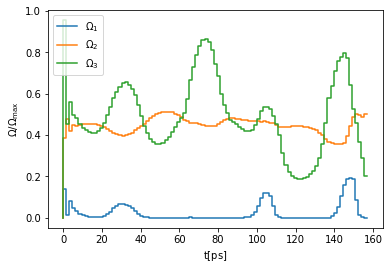

estado


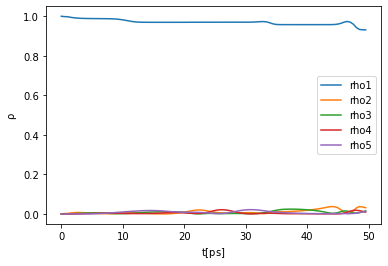

reward


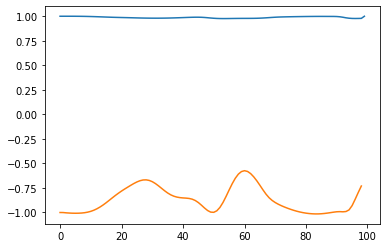

In [ ]:
env = model.get_env()
episode_rewards = []
done = False
obs = env.reset()
actions = []
p1, p2, p3, p4, p5 = [obs[0][0]], [obs[0][6]], [obs[0][12]], [obs[0][18]], [obs[0][24]]
actions.append([[0,0,0]])
obs, reward, done, info = env.step(actions[0])
while not done:
    # _states are only useful when using LSTM policies
    action, _states = model.predict(obs)
    actions.append(action)
    # here, action, rewards and dones are arrays
    # because we are using vectorized env
    obs, reward, done, info = env.step(action)
    p1.append(obs[0][0])
    p2.append(obs[0][6])
    p3.append(obs[0][12])
    p4.append(obs[0][18])
    p5.append(obs[0][24])
    episode_rewards.append(reward)
actions = np.array(actions)
actions.shape

N = len(actions[:,0,0])
tmax = 50*np.pi
tpasos = np.linspace(0,tmax,N)
print('acciones')
plt.xlabel('t[$\mathregular{ps}$]')
plt.ylabel('$\mathregular{\Omega/\Omega_{max}}$')
plt.step(tpasos, actions[:,0,0],label='$\mathregular{\Omega_{1}}$')
plt.step(tpasos, actions[:,0,1],label='$\mathregular{\Omega_{2}}$')
plt.step(tpasos, actions[:,0,2],label='$\mathregular{\Omega_{3}}$')
plt.legend()
path_img = dir_path+'Acciones.png'
file_exists = os.path.exists(path_img)
if not file_exists:
  plt.savefig(dir_path+'Acciones.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
print('estado')
plt.plot(tpasos[:-1]/(np.pi), p1[:-1], label='rho1')
plt.plot(tpasos[:-1]/(np.pi), p2[:-1], label='rho2')
plt.plot(tpasos[:-1]/(np.pi),p3[:-1], label='rho3')
plt.plot(tpasos[:-1]/(np.pi),p4[:-1], label='rho4')
plt.plot(tpasos[:-1]/(np.pi), p5[:-1], label='rho5')
plt.legend()
plt.xlabel('t[$\mathregular{ps}$]')
plt.ylabel('$\mathregular{\\rho}$')

path_img = dir_path+'Estado.png'
file_exists = os.path.exists(path_img)
if not file_exists:
  plt.savefig(dir_path+'Estado.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
ptot = np.array(p1)+np.array(p2)+np.array(p3)
plt.plot(ptot)
print('reward')
plt.plot(episode_rewards)
plt.show()

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/vec_env/dummy_vec_env.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  self.actions[env_idx]


acciones


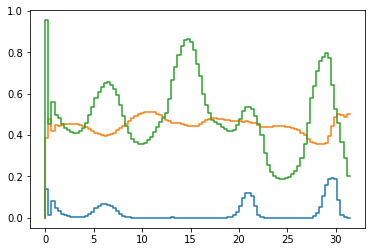

reward


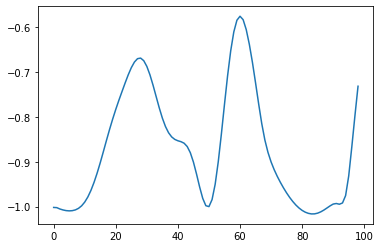

estado


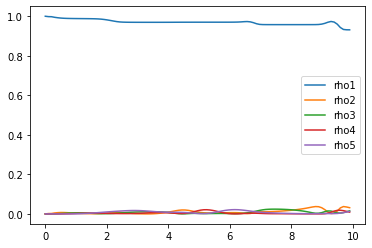

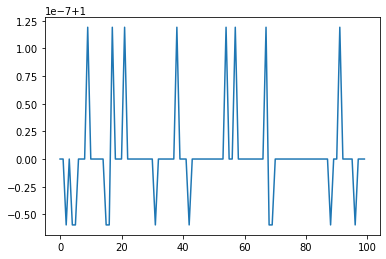

In [ ]:
env = model.get_env()
episode_rewards = []
done = False
obs = env.reset()
actions = []
p1, p2, p3, p4, p5 = [obs[0][0]], [obs[0][6]], [obs[0][12]], [obs[0][18]], [obs[0][24]]
actions.append([[0,0,0]])
obs, reward, done, info = env.step(actions[0])
while not done:
    # _states are only useful when using LSTM policies
    action, _states = model.predict(obs)
    actions.append(action)
    # here, action, rewards and dones are arrays
    # because we are using vectorized env
    obs, reward, done, info = env.step(action)
    p1.append(obs[0][0])
    p2.append(obs[0][6])
    p3.append(obs[0][12])
    p4.append(obs[0][18])
    p5.append(obs[0][24])
    episode_rewards.append(reward)
actions = np.array(actions)
actions.shape

N = 100
omegamax = 1
tmax = 10*np.pi/omegamax
tpasos = np.linspace(0,tmax,N)
print('acciones')
plt.step(tpasos, actions[:,0,0])
plt.step(tpasos, actions[:,0,1])
plt.step(tpasos, actions[:,0,2])
plt.show()
print('reward')
plt.plot(episode_rewards)
plt.show()
print('estado')
plt.plot(tpasos[:-1]/(np.pi/omegamax), p1[:-1], label='rho1')
plt.plot(tpasos[:-1]/(np.pi/omegamax), p2[:-1], label='rho2')
plt.plot(tpasos[:-1]/(np.pi/omegamax),p3[:-1], label='rho3')
plt.plot(tpasos[:-1]/(np.pi/omegamax),p4[:-1], label='rho4')
plt.plot(tpasos[:-1]/(np.pi/omegamax), p5[:-1], label='rho5')
plt.legend()
plt.show()
ptot = np.array(p1)+np.array(p2)+np.array(p3)+np.array(p4)+np.array(p5)
plt.plot(ptot)